# Milestone 3: Logistic Regression - Smooth Convex Duel

This notebook benchmarks **Adam** against **L-BFGS** on a smooth convex surface (Logistic Regression).

## Objectives
1. **Optimizer Comparison**: Contrast first-order adaptive methods with second-order quasi-Newton methods.
2. **Efficiency**: Measure performance relative to a \"compute budget\" (gradient evaluations).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import yaml
from scipy.optimize import minimize

os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

def load_config(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return yaml.safe_load(f)
    return {"n_samples": 1000, "n_features": 20, "alpha": 0.01, "lr": 0.1, "epochs": 50}

config = load_config("configs/logistic.yaml")
print(f"Experiment Configuration: {config}")

Experiment Configuration: {'n_samples': 1000, 'n_features': 20, 'alpha': 0.01, 'lr': 0.1, 'epochs': 50}


## 1. Standalone Components

In [2]:
try:
    from src.losses import LogisticLoss
    from src.reproducibility import set_seed
    print("Successfully imported from src library.")
except ImportError:
    print("src/ not found. Defining core components locally for standalone execution.")

    def set_seed(seed=42):
        np.random.seed(seed)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def logistic_loss(w, X, y, alpha):
        z = X @ w
        h = sigmoid(z)
        h = np.clip(h, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h)) + 0.5 * alpha * np.sum(w**2)
        return loss

    def logistic_grad(w, X, y, alpha):
        n = X.shape[0]
        h = sigmoid(X @ w)
        return (1/n) * X.T @ (h - y) + alpha * w

class AdamOptimizer:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr, self.beta1, self.beta2, self.epsilon = lr, beta1, beta2, epsilon
        self.m, self.v, self.t = 0, 0, 0
    def update(self, w, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad**2)
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        return w - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

set_seed(42)

src/ not found. Defining core components locally for standalone execution.


## 2. Optimizer Duel
We compare Adam and L-BFGS on the same synthetic classification dataset.

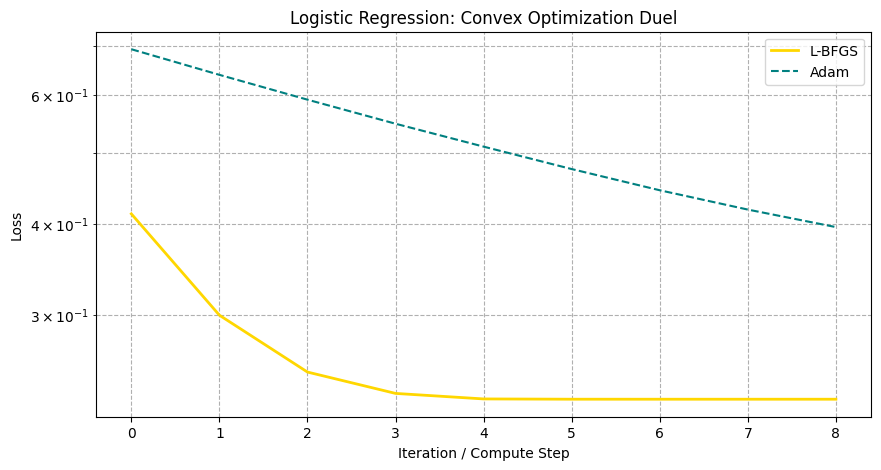

In [3]:
# Generate classification data
X = np.random.randn(config['n_samples'], config['n_features'])
y = (X[:, 0] + X[:, 1] > 0).astype(float)
alpha = config['alpha']
w0 = np.zeros(X.shape[1])

# 1. L-BFGS (SciPy)
lbfgs_history = []
def callback(wk):
    lbfgs_history.append(logistic_loss(wk, X, y, alpha))

res = minimize(
    logistic_loss, w0, args=(X, y, alpha), method='L-BFGS-B',
    jac=logistic_grad, callback=callback, options={'maxiter': config['epochs']}
)

# 2. Adam
adam = AdamOptimizer(lr=config['lr'])
adam_history = []
w_adam = w0.copy()
for _ in range(len(lbfgs_history)):
    adam_history.append(logistic_loss(w_adam, X, y, alpha))
    grad = logistic_grad(w_adam, X, y, alpha)
    w_adam = adam.update(w_adam, grad)

plt.figure(figsize=(10, 5))
plt.plot(lbfgs_history, label="L-BFGS", color='gold', linewidth=2)
plt.plot(adam_history, label="Adam", color='teal', linestyle='--')
plt.yscale('log')
plt.title("Logistic Regression: Convex Optimization Duel")
plt.xlabel("Iteration / Compute Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig("figures/logistic_duel.png")
plt.show()

In [4]:
final_results = {
    "lbfgs_final_loss": float(lbfgs_history[-1]),
    "adam_final_loss": float(adam_history[-1])
}
with open("results/logistic_results.json", "w") as f:
    json.dump(final_results, f, indent=4)
print("Benchmarking complete. Efficiency results saved to results/logistic_results.json")

Benchmarking complete. Efficiency results saved to results/logistic_results.json
